## Importing libiraries

In [ ]:
# Core data analysis libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# For date and time operations
from datetime import datetime

# For file path handling (optional but clean)
import os

# Visualization settings
sns.set(style="whitegrid")
plt.style.use('seaborn-v0_8')

# Suppress warnings for cleaner output (optional)
import warnings
warnings.filterwarnings('ignore')


## Reading Data

In [ ]:
# Define the path to your dataset folder
DATA_PATH = 'D:\Projects\E-Commerce Analytics with Olist Retail Data'  # Change this to your local path

# Load datasets into DataFrames
orders_df = pd.read_csv(os.path.join(DATA_PATH, 'olist_orders_dataset.csv'))
order_items_df = pd.read_csv(os.path.join(DATA_PATH, 'olist_order_items_dataset.csv'))
products_df = pd.read_csv(os.path.join(DATA_PATH, 'olist_products_dataset.csv'))
category_translation_df = pd.read_csv(os.path.join(DATA_PATH, 'product_category_name_translation.csv'))
order_payments_df = pd.read_csv(os.path.join(DATA_PATH, 'olist_order_payments_dataset.csv'))
customers_df = pd.read_csv(os.path.join(DATA_PATH, 'olist_customers_dataset.csv'))
sellers_df = pd.read_csv(os.path.join(DATA_PATH, 'olist_sellers_dataset.csv'))


In [ ]:
# Display first few rows to confirm loading
print("Orders:\n", orders_df.head(), "\n")
print("Order Items:\n", order_items_df.head(), "\n")
print("Products:\n", products_df.head(), "\n")
print("Category Translations:\n", category_translation_df.head(), "\n")
print("Payments:\n", order_payments_df.head(), "\n")
print("Customers:\n", customers_df.head(), "\n")
print("Sellers:\n", sellers_df.head(), "\n")


## orders.csv – Order Status & Timeline Analysis


In [ ]:
# Convert relevant date columns to datetime format
orders_df['order_purchase_timestamp'] = pd.to_datetime(orders_df['order_purchase_timestamp'])
orders_df['order_delivered_customer_date'] = pd.to_datetime(orders_df['order_delivered_customer_date'])
orders_df['order_estimated_delivery_date'] = pd.to_datetime(orders_df['order_estimated_delivery_date'])


In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=orders_df, y='order_status', order=orders_df['order_status'].value_counts().index, palette='Blues_d')
plt.title('Distribution of Order Statuses')
plt.xlabel('Count')
plt.ylabel('Order Status')
plt.tight_layout()
plt.show()


In [ ]:
# Create new column for year-month
orders_df['order_month'] = orders_df['order_purchase_timestamp'].dt.to_period('M')

# Group by month and count orders
monthly_orders = orders_df.groupby('order_month').size().reset_index(name='order_count')

# Convert Period to datetime for plotting
monthly_orders['order_month'] = monthly_orders['order_month'].dt.to_timestamp()

# Plot trend
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_orders, x='order_month', y='order_count', marker='o')
plt.title('Monthly Order Volume Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Calculate delivery time in days (only for delivered orders)
delivered_orders = orders_df[orders_df['order_status'] == 'delivered'].copy()
delivered_orders['delivery_time_days'] = (delivered_orders['order_delivered_customer_date'] - delivered_orders['order_purchase_timestamp']).dt.days

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=delivered_orders, x='delivery_time_days', bins=30, kde=True, color='green')
plt.title('Delivery Time Distribution (in Days) for Delivered Orders')
plt.xlabel('Delivery Time (Days)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


## order_items.csv – Revenue & Product-Level Analysis


In [ ]:
# Calculate total sales value per product (price * item count)
product_sales = order_items_df.groupby('product_id')['price'].sum().reset_index(name='total_sales')

# Sort to find top-selling products
top_products = product_sales.sort_values(by='total_sales', ascending=False).head(10)


In [ ]:
# Plot a horizontal bar chart for the top 10 revenue-generating products
plt.figure(figsize=(12, 6))
sns.barplot(data=top_products, x='total_sales', y='product_id', palette='viridis')
plt.title('Top 10 Products by Revenue')
plt.xlabel('Total Revenue')
plt.ylabel('Product ID')
plt.tight_layout()
plt.show()


In [ ]:
# Plot a histogram of freight_value to show the distribution of shipping costs
plt.figure(figsize=(10, 6))
sns.histplot(order_items_df['freight_value'], bins=40, color='orange', kde=True)
plt.title('Distribution of Shipping Costs (Freight Value)')
plt.xlabel('Shipping Cost')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


In [ ]:
# Merge order_items with orders to bring in the order_purchase_timestamp
order_items_merged = pd.merge(order_items_df, orders_df[['order_id', 'order_purchase_timestamp']], on='order_id', how='left')

# Convert order_purchase_timestamp to period (month) to group by month
order_items_merged['order_month'] = order_items_merged['order_purchase_timestamp'].dt.to_period('M')

# Group by month and calculate total revenue (sum of price)
monthly_revenue = order_items_merged.groupby('order_month')['price'].sum().reset_index()

# Convert month period back to timestamp for plotting
monthly_revenue['order_month'] = monthly_revenue['order_month'].dt.to_timestamp()

# Plot a line chart of monthly revenue trend
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_revenue, x='order_month', y='price', marker='o', color='blue')
plt.title('Monthly Revenue Trend')
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## products.csv + product_category_name_translation.csv – Category-Level Product Analysis


In [ ]:
# Merge products with category name translations to get English category names
products_merged = pd.merge(products_df, category_translation_df, on='product_category_name', how='left')


In [ ]:
# Merge with order_items to get sales info per product and category
product_orders = pd.merge(order_items_df, products_merged[['product_id', 'product_category_name_english']], on='product_id', how='left')

# Group by product category and sum the total price to get total revenue per category
category_sales = product_orders.groupby('product_category_name_english')['price'].sum().reset_index(name='total_revenue')

# Sort to get top 10 revenue-generating categories
top_categories = category_sales.sort_values(by='total_revenue', ascending=False).head(10)


In [ ]:
# Plot a bar chart of the top 10 product categories by revenue
plt.figure(figsize=(12, 6))
sns.barplot(data=top_categories, x='total_revenue', y='product_category_name_english', palette='cubehelix')
plt.title('Top 10 Product Categories by Revenue')
plt.xlabel('Total Revenue')
plt.ylabel('Product Category')
plt.tight_layout()
plt.show()


In [ ]:
# Merge product weight and price for scatter plot
product_details = pd.merge(order_items_df[['product_id', 'price']], products_merged[['product_id', 'product_weight_g']], on='product_id', how='left')

# Drop rows with missing values
product_details = product_details.dropna()

# Plot scatter: product weight vs price
plt.figure(figsize=(10, 6))
sns.scatterplot(data=product_details, x='product_weight_g', y='price', alpha=0.6)
plt.title('Product Weight vs Price')
plt.xlabel('Product Weight (g)')
plt.ylabel('Price')
plt.tight_layout()
plt.show()


## order_payments.csv – Payment Types & Installment Analysis


In [ ]:
# Count how many times each payment type was used
payment_counts = order_payments_df['payment_type'].value_counts().reset_index()
payment_counts.columns = ['payment_type', 'count']


In [ ]:
# Plot a bar chart of how often each payment type was used
plt.figure(figsize=(8, 6))
sns.barplot(data=payment_counts, x='count', y='payment_type', palette='pastel')
plt.title('Payment Type Distribution')
plt.xlabel('Count')
plt.ylabel('Payment Type')
plt.tight_layout()
plt.show()


In [ ]:
# Plot a histogram to show how many customers used how many installments
plt.figure(figsize=(10, 6))
sns.histplot(order_payments_df['payment_installments'], bins=15, color='purple', kde=False)
plt.title('Distribution of Payment Installments')
plt.xlabel('Number of Installments')
plt.ylabel('Number of Payments')
plt.tight_layout()
plt.show()


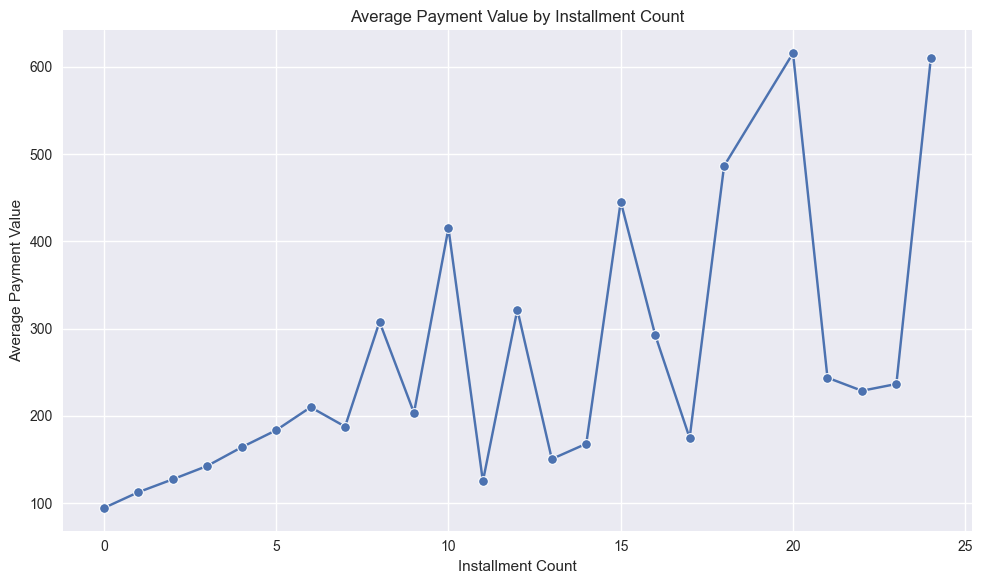

In [56]:
# Group by installment count and calculate average payment value
installment_avg = order_payments_df.groupby('payment_installments')['payment_value'].mean().reset_index()

# Plot average payment value for each installment option
plt.figure(figsize=(10, 6))
sns.lineplot(data=installment_avg, x='payment_installments', y='payment_value', marker='o')
plt.title('Average Payment Value by Installment Count')
plt.xlabel('Installment Count')
plt.ylabel('Average Payment Value')
plt.tight_layout()
plt.show()


## customers.csv – Customer Behavior & Regional Order Trends


In [ ]:
# Merge customer data with orders to analyze order trends by location
customers_orders = pd.merge(orders_df, customers_df, on='customer_id', how='left')

# Count number of orders per customer state
state_orders = customers_orders['customer_state'].value_counts().reset_index()
state_orders.columns = ['customer_state', 'order_count']



In [ ]:
# Select top 10 states for visualization
top_states = state_orders.head(10)

# Plot a horizontal bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=top_states, x='order_count', y='customer_state', palette='crest')
plt.title('Top 10 Customer States by Order Volume')
plt.xlabel('Number of Orders')
plt.ylabel('State')
plt.tight_layout()
plt.show()


In [ ]:
# Create month column from order timestamp
customers_orders['order_month'] = customers_orders['order_purchase_timestamp'].dt.to_period('M')

# Select top 3 states by number of orders
top_3_states = state_orders.head(3)['customer_state'].tolist()

# Filter for just those states
filtered_states = customers_orders[customers_orders['customer_state'].isin(top_3_states)]

# Group by state and month
monthly_state_orders = (
    filtered_states
    .groupby(['order_month', 'customer_state'])
    .size()
    .reset_index(name='order_count')
)
monthly_state_orders['order_month'] = monthly_state_orders['order_month'].dt.to_timestamp()

# Plot line chart
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_state_orders, x='order_month', y='order_count', hue='customer_state', marker='o')
plt.title('Monthly Order Trends for Top 3 States')
plt.xlabel('Month')
plt.ylabel('Order Count')
plt.xticks(rotation=45)
plt.legend(title='State')
plt.tight_layout()
plt.show()


## sellers.csv – Seller Performance & Location-Based Sales


In [ ]:
# Merge seller info into order_items to analyze seller sales
sellers_merged = pd.merge(order_items_df, sellers_df, on='seller_id', how='left')

# Group by seller_id and sum the total price (sales revenue)
seller_revenue = sellers_merged.groupby('seller_id')['price'].sum().reset_index(name='total_revenue')

# Sort and get top 10 sellers
top_sellers = seller_revenue.sort_values(by='total_revenue', ascending=False).head(10)



In [ ]:
# Plot a horizontal bar chart for top 10 revenue-generating sellers
plt.figure(figsize=(12, 6))
sns.barplot(data=top_sellers, x='total_revenue', y='seller_id', palette='flare')
plt.title('Top 10 Sellers by Total Revenue')
plt.xlabel('Total Revenue')
plt.ylabel('Seller ID')
plt.tight_layout()
plt.show()


In [ ]:
# Count how many sellers are in each state
seller_state_counts = sellers_df['seller_state'].value_counts().reset_index()
seller_state_counts.columns = ['seller_state', 'seller_count']


In [ ]:
# Get top 10 seller states
top_seller_states = seller_state_counts.head(10)

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=top_seller_states, x='seller_count', y='seller_state', palette='mako')
plt.title('Top 10 States by Number of Sellers')
plt.xlabel('Number of Sellers')
plt.ylabel('State')
plt.tight_layout()
plt.show()


## Combined Trend Analysis – Orders, Revenue & Payments Over Time


In [ ]:
# Merge order_items with order dates
items_with_date = pd.merge(order_items_df, orders_df[['order_id', 'order_purchase_timestamp']], on='order_id', how='left')

# Extract month from timestamp
items_with_date['order_month'] = items_with_date['order_purchase_timestamp'].dt.to_period('M')

# Group by month and calculate average freight
monthly_avg_freight = items_with_date.groupby('order_month')['freight_value'].mean().reset_index()
monthly_avg_freight['order_month'] = monthly_avg_freight['order_month'].dt.to_timestamp()

# Plot average freight over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_avg_freight, x='order_month', y='freight_value', marker='o', color='darkgreen')
plt.title('Average Shipping Cost per Month')
plt.xlabel('Month')
plt.ylabel('Avg. Freight Value (Shipping Cost)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Join order_items with orders to bring order date
items_with_sellers = pd.merge(order_items_df[['order_id', 'seller_id']], orders_df[['order_id', 'order_purchase_timestamp']], on='order_id', how='left')

# Create order_month column
items_with_sellers['order_month'] = items_with_sellers['order_purchase_timestamp'].dt.to_period('M')

# Count unique sellers per month
monthly_seller_count = items_with_sellers.groupby('order_month')['seller_id'].nunique().reset_index(name='unique_sellers')
monthly_seller_count['order_month'] = monthly_seller_count['order_month'].dt.to_timestamp()

# Plot unique seller count over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_seller_count, x='order_month', y='unique_sellers', marker='o', color='steelblue')
plt.title('Number of Unique Active Sellers per Month')
plt.xlabel('Month')
plt.ylabel('Unique Sellers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


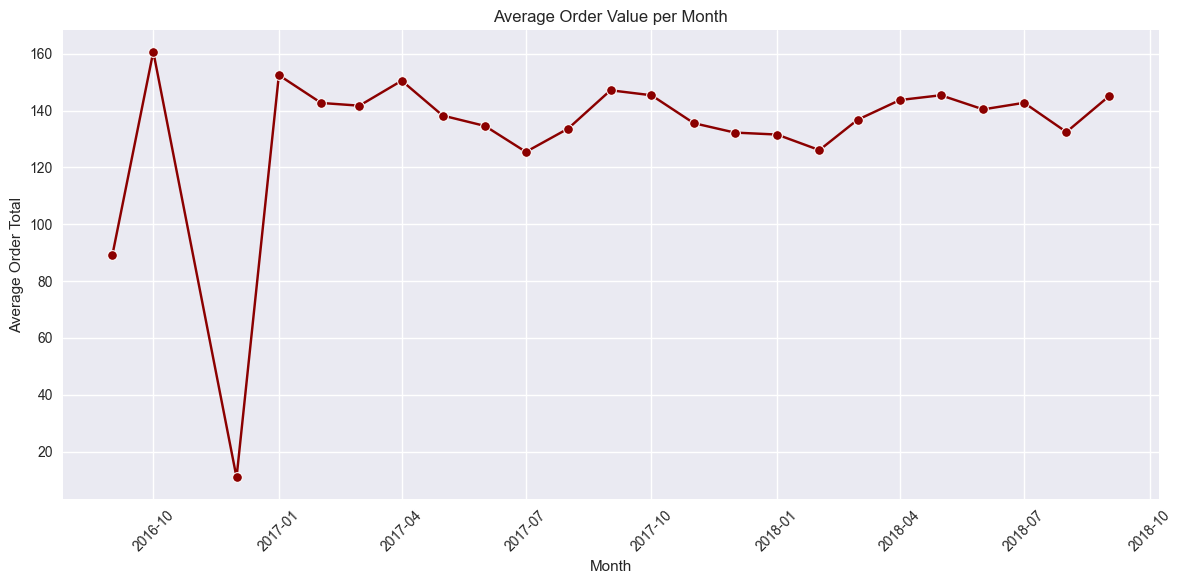

In [55]:
# Merge order_items with order dates and group by order_id to get total order value
order_value = order_items_df.groupby('order_id')['price'].sum().reset_index(name='order_total')
order_value = pd.merge(order_value, orders_df[['order_id', 'order_purchase_timestamp']], on='order_id', how='left')

# Extract month and compute monthly average order value
order_value['order_month'] = order_value['order_purchase_timestamp'].dt.to_period('M')
monthly_avg_order_value = order_value.groupby('order_month')['order_total'].mean().reset_index()
monthly_avg_order_value['order_month'] = monthly_avg_order_value['order_month'].dt.to_timestamp()

# Plot average order value trend
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_avg_order_value, x='order_month', y='order_total', marker='o', color='darkred')
plt.title('Average Order Value per Month')
plt.xlabel('Month')
plt.ylabel('Average Order Total')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
